## Classification of MNIST with CNN

: Convolutional Neural Network

In [21]:
import os
import time
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Data Load

In [8]:
mnist_train = datasets.MNIST(
    root="mnist", 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    root="mnist", 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

### Preprocess

In [9]:
class mnist_dataset(Dataset):
    """
    It returns a transformed pair of data and target if you input index value.
    """
    def __init__(self, data, targets, transform=None, target_transform=None):
        super().__init__()

        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx], self.targets[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return x, y

In [10]:
def split_train_valid(dataset, valid_ratio=0.1):
    """
    A function that creates validation dataset from training dataset.
    """
    n_valid = int(len(dataset) * valid_ratio)

    train_data = np.array(dataset.data[:-n_valid])
    valid_data = np.array(dataset.data[-n_valid:])
    train_targets = dataset.targets[:-n_valid]
    valid_targets = dataset.targets[-n_valid:]

    train = mnist_dataset(data=train_data, 
                          targets=train_targets, 
                          transform=dataset.transform, 
                          target_transform=dataset.target_transform)
    valid = mnist_dataset(data=valid_data, 
                          targets=valid_targets, 
                          transform=dataset.transform, 
                          target_transform=dataset.target_transform)

    return train, valid

In [11]:
print(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train
    StandardTransform
Transform: ToTensor()


In [12]:
mnist_train, mnist_valid = split_train_valid(dataset=mnist_train)

In [13]:
# It is better to shuffle if the dataset is for training.
train_loader = DataLoader(dataset=mnist_train, 
                          batch_size=64, 
                          shuffle=True, 
                          drop_last=True) 
valid_loader = DataLoader(dataset=mnist_valid, 
                          batch_size=64, 
                          shuffle=False, 
                          drop_last=True)   
test_loader = DataLoader(dataset=mnist_test, 
                         batch_size=64, 
                         shuffle=False, 
                         drop_last=True)

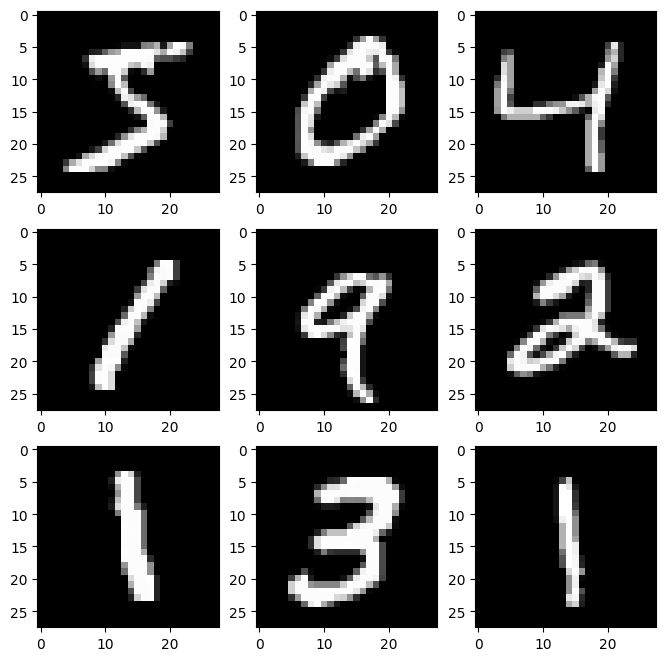

In [15]:
# Check the images.
fig = plt.figure(figsize=(8, 8))
for i in range(9):
    img = mnist_train[i][0]
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(img.reshape(28, 28), cmap="gray")

### Model

In [16]:
class SimpleCNNClassifier(nn.Module):
    def __init__(self, n_class=10):
        super().__init__()

        ## Separate each layers to visualize filters
        ## nn.Conv2d : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d
        ## nn.Maxpool2d : https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*3*32, 32)
        self.fc2 = nn.Linear(32, 10) 
        # You can also build a model with nn.Sequential.

    def forward(self, x, visualize_filter=False):
        conv1 = self.conv1(x)
        _conv1 = self.pool(self.relu(conv1))
        conv2 = self.conv2(_conv1)
        _conv2 = self.pool(self.relu(conv2))
        conv3 = self.conv3(_conv2)
        _conv3 = self.pool(self.relu(conv3))
        conv3_vec = self.flatten(_conv3)
        fc1 = self.fc1(conv3_vec)
        out = self.fc2(self.relu(fc1))

        # If you use nn.Sequential,
        # out = self.mode(x)

        if not visualize_filter:    # In general
            return out
        else:                       # If you want the check the convolutional filter
            return conv1, conv2, conv3,out

In [17]:
cnn = SimpleCNNClassifier()

In [19]:
# Check the structure of the CNN model.
sample_x = mnist_valid[0][0].unsqueeze(dim=0)
print("Shape of sample:", sample_x.shape) 
conv1, conv2, conv3,out = cnn(sample_x, visualize_filter=True)
print(conv1.shape, conv2.shape, conv3.shape, out.shape)

Shape of sample: torch.Size([1, 1, 28, 28])
torch.Size([1, 32, 28, 28]) torch.Size([1, 32, 14, 14]) torch.Size([1, 32, 7, 7]) torch.Size([1, 10])


### Train the model

In [22]:
# To check the time period.
start_time = time.time() 
time_interval = time.time() - start_time

In [23]:
class Trainer(nn.Module):
    def __init__(self, model, opt="adam", lr=0.001, has_scheduler=False, device="cpu"):
        """
        Args:
        model: A classification model that you want to use
        n_class: Number of class 
        opt: Optimizer
        lr: Learning rate
        has_scheduler: True if you want to use the learning rate scheduler
        device: Device that you are using for the training(cpu/cuda).
        """
        super().__init__()

        self.model = model 
        self.loss = nn.CrossEntropyLoss()

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device

    def _get_optimizer(self, opt, lr=0.001):
        """
        Args:
        opt: Optimizer
        lr: Learning rate
        """
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"Optimizer {opt} is not supproted.")

    def _get_scheduler(self):
        # self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)

    def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=5):
        """
        A function to train the CNN model.
        Args:
        train_loader: Train dataset loader
        valid_loader: Validation dataset loader
        max_epochs: Number of epochs
        disp_epochs: Number of epoch frequency to display training logs
        """
        print("===== Train Starts. =====")
        start_time = time.time()   
        history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
        for e in range(max_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            valid_loss, valid_acc = self._valid_epoch(valid_loader)
            
            # Record the performances.
            history["train_loss"].append(train_loss)
            history["train_acc"].append(train_acc)
            history["valid_loss"].append(valid_loss)
            history["valid_acc"].append(valid_acc)

            if self.has_scheduler: # Step size will be adjusted if the scheduler is on.
                self.scheduler.step()

            if e % disp_epoch == 0:
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}, time: {time.time()-start_time:>3f}")
                start_time = time.time()   

        self.plot_history(history)

    def _train_epoch(self, train_loader):
        """
        A function that trains the model by each epoch
        Args:
        train_loader: Train dataset loader
        Returns: Average loss and accuracy
        """
        epoch_loss, epoch_acc = 0, 0
        self.model.train()
        for (x, y) in train_loader:
            x = x.to(self.device)
            y = y.to(self.device)

            y_hat = self.model(x) # Predicted label by the model 
            loss = self.loss(y_hat, y)       

            self.optimizer.zero_grad() # Update network parameters through backwardpass
            loss.backward()
            self.optimizer.step() 

            epoch_loss += loss.to("cpu").item()    
            epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

        epoch_loss /= len(train_loader)  
        epoch_acc /= len(train_loader)

        return epoch_loss, epoch_acc

    def _valid_epoch(self, valid_loader):
        """
        A function that evaluate the current model with validation dataset.
        Args:
        valid_loader: Validation dataset loader
        Returns: Average loss and accuracy
        """
        epoch_loss, epoch_acc = 0, 0
        self.model.eval() # Change the mode for the evaluation.
        with torch.no_grad(): # Do not calculate the gradient loss to the model.
            for (x, y) in valid_loader:
                x = x.to(self.device)
                y = y.to(self.device)

                y_hat = self.model(x)
                loss = self.loss(y_hat, y)

                epoch_loss += loss.to("cpu").item()
                epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

        epoch_loss /= len(valid_loader)
        epoch_acc /= len(valid_loader)

        return epoch_loss, epoch_acc

    def plot_history(self, history):
        """
        Plot the history
        Args:
        history: dictionary with keys {"train_loss", "train_acc", "valid_loss", "valid_acc" }
        """
        fig = plt.figure(figsize=(20, 10))

        ax = fig.add_subplot(1, 2, 1)
        ax.plot(history["train_loss"], color="red", label="train loss")
        ax.plot(history["valid_loss"], color="blue", label="valid loss")
        ax.set_title("Loss")
        ax.legend()

        ax = fig.add_subplot(1, 2, 2)
        ax.plot(history["train_acc"], color="red", label="train acc")
        ax.plot(history["valid_acc"], color="blue", label="valid acc")
        ax.set_title("Acc")
        ax.legend()

    def test(self, test_loader):
        """
        A function to evaluate the model with test dataset.
        Args:
        test_loader: Test dataset loader
        Returns: Average loss and accuracy
        """
        print("===== Test Starts. =====")
        start_time = time.time()
        epoch_loss, epoch_acc = 0, 0
        self.model.eval()
        with torch.no_grad():
            for (x, y) in test_loader:
                x = x.to(self.device)
                y = y.to(self.device)

                y_hat = self.model(x)
                loss = self.loss(y_hat, y)

                epoch_loss += loss.to("cpu").item()
                epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

        epoch_loss /= len(test_loader)
        epoch_acc /= len(test_loader)

        print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}, time: {time.time()-start_time:>3f}")

===== Train Starts. =====
Epoch: 0, train loss: 0.307657, train acc: 0.903062, valid loss: 0.081574, valid acc: 0.975470, time: 69.682068
Epoch: 1, train loss: 0.080209, train acc: 0.974681, valid loss: 0.061993, valid acc: 0.982863, time: 68.043476
Epoch: 2, train loss: 0.057761, train acc: 0.982188, valid loss: 0.047060, valid acc: 0.985215, time: 59.548827
Epoch: 3, train loss: 0.046549, train acc: 0.985320, valid loss: 0.042013, valid acc: 0.987903, time: 58.087728
Epoch: 4, train loss: 0.038137, train acc: 0.987248, valid loss: 0.041340, valid acc: 0.989583, time: 64.624357
Epoch: 5, train loss: 0.032436, train acc: 0.989231, valid loss: 0.035501, valid acc: 0.990591, time: 62.583922
Epoch: 6, train loss: 0.028088, train acc: 0.990677, valid loss: 0.045345, valid acc: 0.987399, time: 61.463712
Epoch: 7, train loss: 0.023953, train acc: 0.991974, valid loss: 0.040428, valid acc: 0.990255, time: 61.595387
Epoch: 8, train loss: 0.020641, train acc: 0.993198, valid loss: 0.040001, val

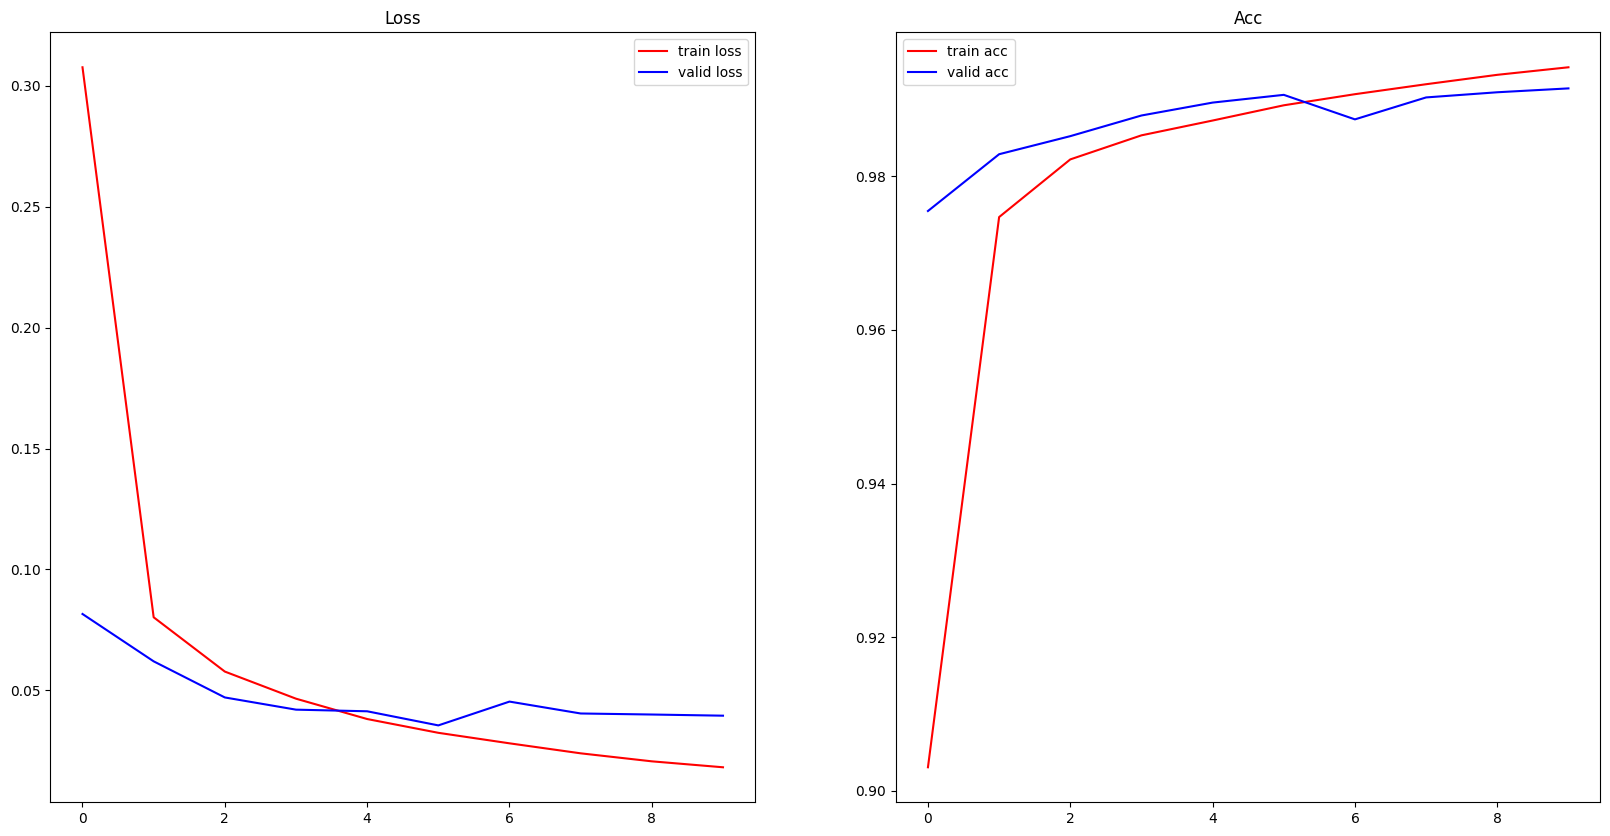

In [26]:
device = "cpu" # "cuda" if you are using GPU.
cnn = SimpleCNNClassifier(n_class=10)

trainer = Trainer(model=cnn,
                  opt="adam", 
                  lr=0.001, 
                  has_scheduler=False, 
                  device=device).to(device)
start_time = time.time()

trainer.train(train_loader, valid_loader, max_epochs=10, disp_epoch=1)

print(f"Training time : {time.time()-start_time:>3f}")
trainer.test(test_loader)

In [27]:
print("Model's state_dict:")
for param_tensor in cnn.state_dict():
    print(f"{param_tensor}, \t {cnn.state_dict()[param_tensor].size()}")

Model's state_dict:
conv1.weight, 	 torch.Size([32, 1, 5, 5])
conv1.bias, 	 torch.Size([32])
conv2.weight, 	 torch.Size([32, 32, 3, 3])
conv2.bias, 	 torch.Size([32])
conv3.weight, 	 torch.Size([32, 32, 3, 3])
conv3.bias, 	 torch.Size([32])
fc1.weight, 	 torch.Size([32, 288])
fc1.bias, 	 torch.Size([32])
fc2.weight, 	 torch.Size([10, 32])
fc2.bias, 	 torch.Size([10])


In [ ]:
# Save the model.
model_dir = os.path.join(os.getcwd(), "model", "CNN_model")
if not os.path.exists(model_dir): os.makedirs(model_dir) # If model_dir doesn't exist.
torch.save(cnn.state_dict(), os.path.join(model_dir, "SimpleCNNClassifier.pth"))

In [ ]:
# Load the model.
model_path = os.path.join(model_dir, "SimpleCNNClassifier.pth")
cnn_load.load_state_dict(torch.load(model_path))
cnn_load.eval()

In [28]:
# Check the performance of the untrained model.
cnn_load = SimpleCNNClassifier(n_class=10)
trainer_not_load = Trainer(model=cnn_load, 
                           opt="adam", 
                           lr=0.001, 
                           has_scheduler=False, 
                           device=device).to(device)

trainer_not_load.test(test_loader)

===== Test Start =====
Test loss: 2.306246, Test acc: 0.099259, time: 5.953084
